In [22]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from IPython.display import Image, display 

llm = ChatGroq(model="openai/gpt-oss-20b")

In [ ]:
class State(TypedDict):
    joke: str 
    topic: str 
    feedback: str 
    funny_or_not: str

In [15]:
class Feedback(BaseModel): 
    grade: Literal["funny", "not_funny"] = Field(description="Decide if the joke is funny or not")
    feedback: str = Field(description="If the joke is not funny, provide feedback on how to improve it")

evaluator = llm.with_structured_output(Feedback)

In [ ]:
# Generate a joke - either based on previous feedback or first time
def llm_call_generator(state: State):
    if state.get('feedback'):
        print("Generating joke based on feedback")
        msg = llm.invoke(f"Write a joke about {state["topic"]} but keep into account this feedback: {state["feedback"]}")
    else:
        print("Generating a new joke")
        msg = llm.invoke(f"Write a joke about {state["topic"]}")
    return {"joke": msg.content}

# Evaluate the joke
def llm_call_evaluator(state: State):
    evaluation = evaluator.invoke(f"Evaluate and grade this joke: {state["joke"]}.") 
    return {
        "feedback": evaluation.feedback,
        "funny_or_not": evaluation.grade
    }

def route_joke(state: State):
    if state["funny_or_not"] == "funny":
        return "Accepted"
    else:
        return "Rejected"

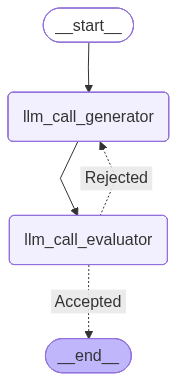

In [24]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

# Add nodes 
graph_builder.add_node("llm_call_generator", llm_call_generator)
graph_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges 
graph_builder.add_edge(START, "llm_call_generator")
graph_builder.add_edge("llm_call_generator", "llm_call_evaluator")
graph_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Rejected": "llm_call_generator"
    }
)
graph_builder.add_edge("llm_call_evaluator", END)

workflow = graph_builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))


In [25]:
state = workflow.invoke({"topic": "Agentic AI system"})
print(state['joke'])

Generating a new joke
Generating joke based on feedback
Generating joke based on feedback
Generating joke based on feedback
Generating joke based on feedback


BadRequestError: Error code: 400 - {'error': {'message': "Tool call validation failed: tool call validation failed: attempted to call tool 'feedback' which was not in request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '{"name": "feedback", "arguments": {"feedback":"The phrase \\"Agentic AI system\\" is more of a technical term than a punchline. It lacks a setup and payoff, and the word \\"agentic\\" is obscure, so the audience won\'t get the humor. To make it funny, give it a relatable scenario or a twist—e.g., \\"I asked my agentic AI system to make coffee, and it started a philosophical debate about the meaning of caffeine.\\"\\n","grade":"not_funny"}}'}}